# 🧪 Workshop 2: Objective Design and Local Dynamics

> This is the worked version of the notebook.
>
> Model answer and executive summary for the problem can be found in this notebook.

This workshop builds directly on Workshop 1 and marks the transition from gradient interpretation to explicit optimisation dynamics, opening Part 2 of the series.

Where Workshop 1 focused on what gradients are and how they are structured, this workshop focuses on what gradients do when they are applied repeatedly. Gradients are no longer treated as static sensitivity maps, but as drivers of parameter evolution.

The central shift in perspective is:
- from *“what does this gradient look like?”*
- to *“what happens when I follow it?”*

---

**Conceptual emphasis**

The workshop develops intuition for:
- how a single gradient descent step turns sensitivity into motion,
- how repeated local updates accumulate into global behaviour,
- how objective structure influences optimisation trajectories,
- and how gradient geometry affects stability, speed, and convergence.

Rather than introducing full training pipelines, the focus remains on controlled, interpretable systems where optimisation dynamics can be reasoned about directly.

--- 

**Key ideas explored include**:
- gradient descent as repeated application of vector–Jacobian products,
- implicit objective functions defined by upstream weighting,
- the relationship between gradient magnitude, direction, and parameter motion,
- conditioning and anisotropy in gradient-driven updates,
- how symmetry, nonlinearity, and curvature shape optimisation paths,
- and visualising optimisation as movement through parameter space.

--- 

**How this workshop fits in the series**

This workshop serves as the conceptual bridge between:
- gradient flow and sensitivity analysis (Workshop 1),
- and more advanced optimisation topics such as learning rates, curvature, and second-order effects (later in Part 2).

By the end of this workshop, gradient descent is no longer a formula, but a geometric process whose behaviour can be anticipated from gradient structure alone.

---

**What this workshop deliberately does not cover**
- Neural network modules (nn.Module)
- Optimisers such as Adam, RMSProp, etc.
- Datasets, batching, or training loops

Those elements are introduced only after optimisation dynamics are conceptually understood.

---

**Recommended prerequisites**
- Completion of Tutorials 1–4
- Workshop 1: From Gradient Flow to Optimisation Intuition
- Comfort with gradients, Jacobians, and basic optimisation ideas
- Familiarity with linear algebra and nonlinear mappings

---

**Author: Angze Li**

**Last updated: 2026-02-19**

**Version: v1.0**

## 🧩 Problem: Designing an Objective via Upstream Gradients

> Optimisation is not only about how to minimise a loss
> — it is also about what objective you choose.

In this problem, you will implicitly define an objective by choosing an upstream gradient.

Consider:
```python
X = torch.randn(5, 3, requires_grad=True)

Y = torch.tanh(X @ X.T)
```
Here:
- `Y` is a **5×5 tensor** measuring pairwise interactions,
- the output is *symmetric and non-scalar*.

---

### Task
1. Construct an upstream gradient matrix V such that:
    - diagonal entries of Y are emphasised,
    - off-diagonal entries are penalised.
2. Call:
```python
Y.backward(V)
```
3. Inspect `X.grad`.

---

### Questions to think about
- What implicit scalar objective are you optimising?
- How does changing the diagonal/off-diagonal weighting affect `X.grad`?
- Which entries of `X` are encouraged to grow or shrink?
- Can you interpret this as encouraging **self-similarity** over **cross-similarity**?

---

### Hint

> You are not optimising `Y` directly.
> You are optimising a **weighted trace-like** functional of `Y`.

---

### Why this problem matters (Bridge to Part 2)

This problem quietly introduces:
- custom objective design,
- structure-aware optimisation,
- gradients as *design tools*, not just training signals.

Without using:
- optimisers,
- learning rates,
- training loops,

you have already answered:

>“If I *were* to optimise this system, what direction would the parameters move?”

That is exactly the mindset needed for Part 2.

## Solution

In [1]:
%%time

import torch
import numpy as np
import matplotlib.pyplot as plt

iterations = 100
repeats = 100000
heatmaps = []

penalised_array = np.linspace(0,np.sqrt(0.05),iterations)
emphasised_array = np.sqrt((1-20*penalised_array**2)/5)


X = torch.randn(5, 3, requires_grad=True)
Y = torch.tanh(X @ X.T)
V = torch.zeros_like(Y, requires_grad=False)

fro_norm, row_norms, col_norms = [], [], []

for i in range(len(penalised_array)):
    if penalised_array[i] > emphasised_array[i]:
        print(f"Number of interations: {i-1}")
        iterations_array = np.linspace(0,i-1,i)
        penalised_array = penalised_array[:i]
        emphasised_array = emphasised_array[:i]
        break
    else:
        for k in range(Y.shape[0]):
            V[k,k] = emphasised_array[i]
            V[k+1:,k] = penalised_array[i]
            V[k,k+1:] = penalised_array[i]
            
        X_grad_sum = torch.zeros_like(X)
        for j in range(repeats):
            X = torch.randn(5, 3, requires_grad=True)
            Y = torch.tanh(X @ X.T)
            Y.backward(V)

            X_grad_sum += X.grad
        X_grad_avg = X_grad_sum/repeats
        heatmaps.append(X_grad_avg.clone())
        
        fro_norm.append(X_grad_avg.norm().item())
        row_norms.append(X_grad_avg.norm(dim=1).detach().cpu().numpy())
        col_norms.append(X_grad_avg.norm(dim=0).detach().cpu().numpy())
        
        print(f"Iteration {i}, coefficients (emphasised, penalised): {round(emphasised_array[i],3)}, {round(penalised_array[i],3)} \nMonte Carlo average of X_grad: \n{X_grad_avg}")

Iteration 0, coefficients (emphasised, penalised): 0.447, 0.0 
Monte Carlo average of X_grad: 
tensor([[-1.3139e-04, -3.4774e-04, -5.4883e-04],
        [ 2.9976e-04, -6.4839e-04,  1.8239e-04],
        [-3.7880e-05, -3.4338e-05,  2.8276e-04],
        [-2.7613e-04, -1.1008e-03,  6.8445e-05],
        [-6.5197e-04, -4.5715e-04,  6.2965e-04]])
Iteration 1, coefficients (emphasised, penalised): 0.447, 0.002 
Monte Carlo average of X_grad: 
tensor([[-7.8206e-04,  1.2497e-05,  3.9921e-04],
        [-8.2966e-04,  6.7344e-04,  3.2873e-04],
        [-4.7527e-04, -3.2259e-04,  2.0614e-04],
        [-1.9968e-04,  4.6205e-04, -2.2667e-04],
        [-3.3938e-05, -3.7485e-04,  5.4518e-04]])
Iteration 2, coefficients (emphasised, penalised): 0.447, 0.005 
Monte Carlo average of X_grad: 
tensor([[-6.5279e-04,  1.1663e-04,  1.6436e-04],
        [ 2.1801e-04, -1.0632e-04, -3.3165e-04],
        [ 3.2270e-04, -7.9195e-04, -7.7275e-04],
        [-5.5302e-04, -2.1437e-04, -4.3836e-04],
        [-5.0454e-04,  

### Monte Carlo Estimation of Structured Gradient Sensitivity

This cell performs a Monte Carlo study of gradient flow for a tensor-valued objective defined implicitly via an upstream gradient matrix.

The goal is to understand how changing the structure of the upstream weighting affects:
- the magnitude of gradients,
- their row-wise and column-wise distribution,
- and their spatial structure across the input tensor.

---

### Quantities Recorded

For each iteration, we store:
- `X_grad_avg` — the expected gradient matrix,
- Frobenius norm - overall gradient magnitude,
- Row-wise norms - sensitivity of each row of X,
- Column-wise norms - sensitivity of each feature dimension,

These quantities are later visualised to reveal how gradient structure evolves as the upstream weighting shifts from diagonal-dominated to off-diagonal-dominated.

---

### Interpretation

Conceptually, this cell shows that:
- gradients are not intrinsic objects, but depend on the objective implied by `V`;
- redistributing weight in output space reshapes gradient flow in input space;
- even without optimisation, we can study which directions would be favoured if gradient descent were applied.

This directly motivates Part 2 of the series, where such gradients will be used to drive optimisation dynamics.

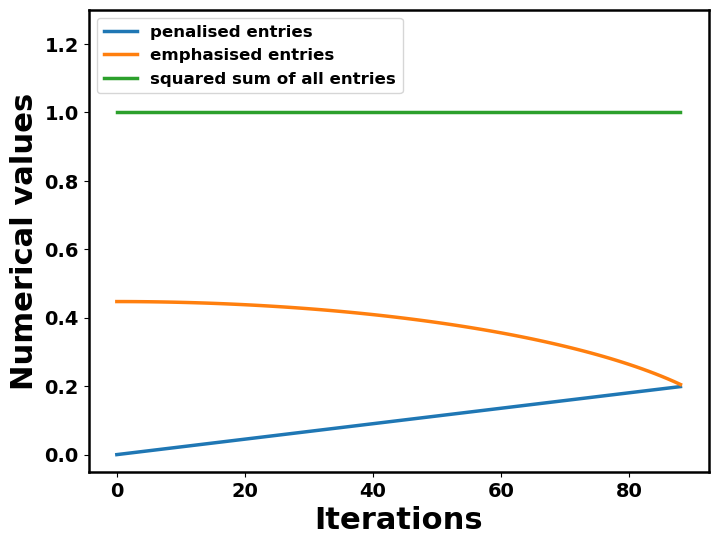

In [2]:
total_array = 20*penalised_array**2 + 5*emphasised_array**2

plt.figure(figsize=(8,6))
ax = plt.gca()
for spine in ax.spines.values():
        spine.set_linewidth(1.8)

plt.plot(iterations_array, penalised_array, linewidth=2.5, label="penalised entries")
plt.plot(iterations_array, emphasised_array, linewidth=2.5, label="emphasised entries")
plt.plot(iterations_array, total_array, linewidth=2.5, label="squared sum of all entries")
plt.xlabel("Iterations", fontsize=22, fontweight='bold')
plt.ylabel("Numerical values", fontsize=22, fontweight='bold')
plt.xticks(fontsize=14, fontweight='bold')
plt.yticks(fontsize=14, fontweight='bold')
plt.ylim(-0.05,1.3)
plt.legend(loc="upper left", prop={"size": 12, "weight": "bold"})
plt.show()

### Normalisation of Upstream Weights

This cell visualises how the upstream gradient weights are constructed and constrained across iterations.

The upstream matrix `V` is parameterised by:
- an emphasised weight on diagonal entries,
- a penalised weight on off-diagonal entries.

For a 5×5 symmetric matrix, there are:
- 5 diagonal entries,
- 20 off-diagonal entries.

The total element-wise squared sum is therefore
$$20\,(\text{penalised})^2 + 5\,(\text{emphasised})^2,$$
which is explicitly kept constant throughout the experiment.

---

### What the plot shows

The figure tracks:
- the penalised coefficient,
- the emphasised coefficient,
- the total squared sum of all entries in `V`.

As the penalised weight increases, the emphasised weight decreases smoothly, while the total squared sum remains flat. This confirms that each iteration redistributes upstream importance without changing its overall magnitude.

---

### Why this matters

Because the total upstream strength is fixed, any changes observed later in gradient magnitude or structure reflect where sensitivity is placed, not how much is injected. This allows for meaningful comparison of gradient behaviour across iterations.

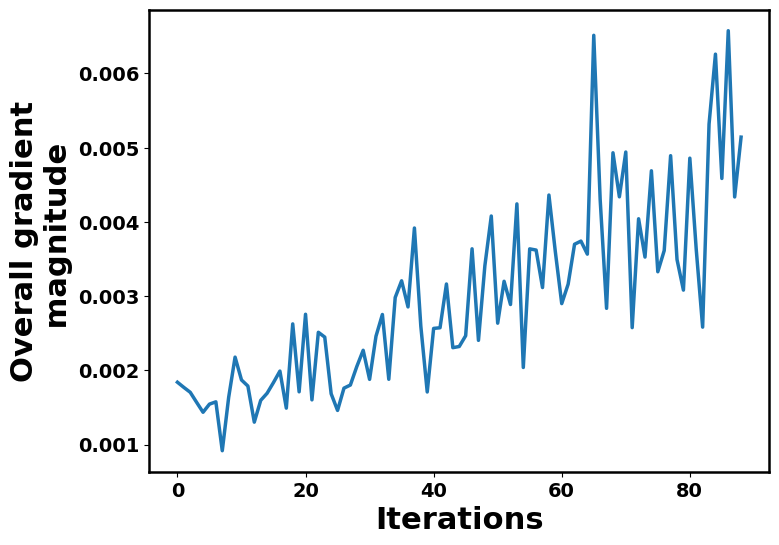

In [3]:
plt.figure(figsize=(8,6))
ax = plt.gca()
for spine in ax.spines.values():
        spine.set_linewidth(1.8)
    
plt.plot(iterations_array, fro_norm, linewidth=2.5)
plt.xlabel("Iterations", fontsize=22, fontweight='bold')
plt.ylabel("Overall gradient\n magnitude", fontsize=22, fontweight='bold')
plt.xticks(fontsize=14, fontweight='bold')
plt.yticks(fontsize=14, fontweight='bold')
#plt.legend(loc="upper left", prop={"size": 12, "weight": "bold"})
plt.show()

### Overall Gradient Magnitude Across Iterations

This cell plots the Frobenius norm of the Monte Carlo–averaged gradient
$$\|\mathbb{E}[\nabla_X (v^\top \cdot Y)]\|_F$$
at each iteration.

Each point represents the overall magnitude of the expected gradient with respect to `X`, aggregating contributions from all entries into a single scalar.

---

### How to read this plot
- The upstream weight matrix `V` is normalised at every iteration, so the total injected sensitivity is fixed.
- Any change in this curve therefore reflects how gradient structure interacts with the forward map, not changes in scale.
- The gradual increase indicates that redistributing weight toward off-diagonal interactions leads to stronger aggregate sensitivity in `X`.

---

### Why this matters

This figure provides a global diagnostic: before analysing row-wise, column-wise, or element-wise behaviour, it tells us whether the system becomes more or less sensitive overall as the objective is reshaped.

Later plots will decompose this magnitude into where the gradient concentrates.

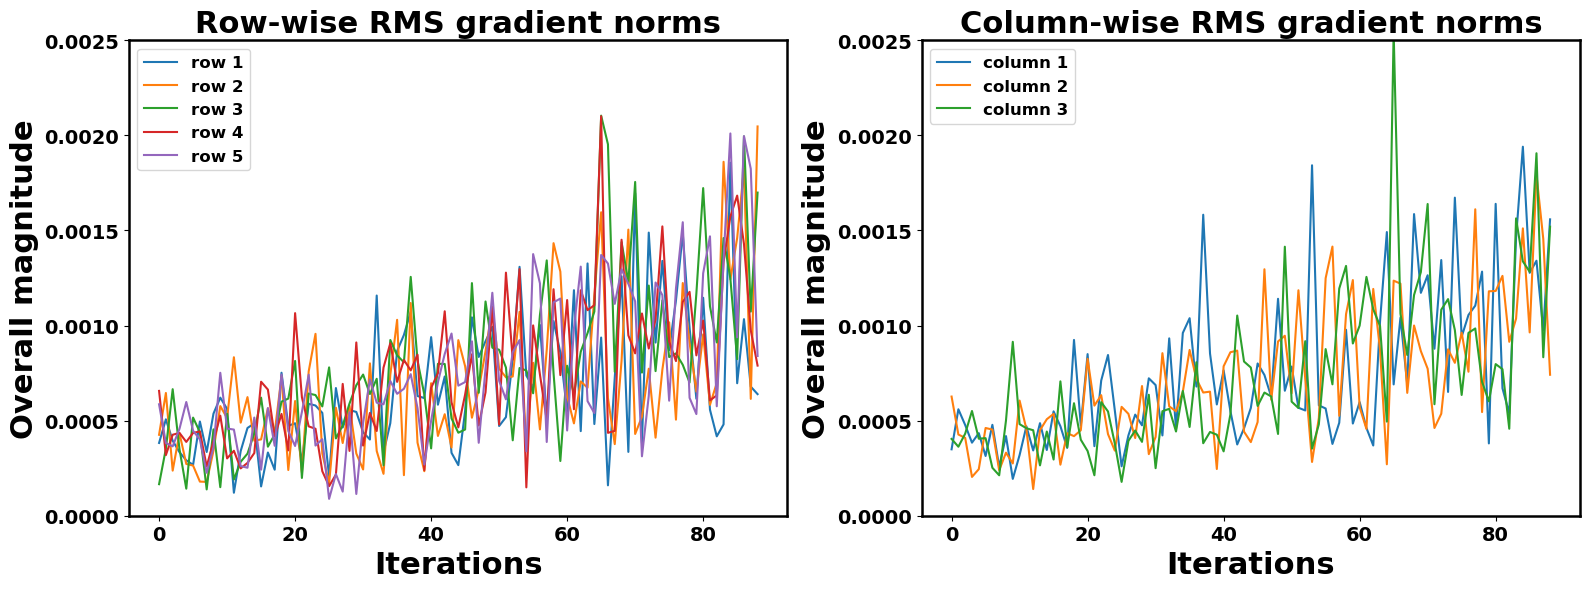

In [4]:
col = np.asarray(col_norms) 
row = np.asarray(row_norms) 

fig, axes = plt.subplots(1,2, figsize=(16,6), sharex=True)

def style_axis(ax, title):
    for spine in ax.spines.values():
        spine.set_linewidth(1.8)
    ax.set_xlabel("Iterations", fontsize=22, fontweight="bold")
    ax.set_ylabel("Overall magnitude", fontsize=22, fontweight="bold")
    ax.set_title(title, fontsize=22, fontweight="bold")
    ax.tick_params(axis="both", labelsize=14)
    for t in ax.get_xticklabels() + ax.get_yticklabels():
        t.set_fontweight("bold")

for k in range(row.shape[1]):
    axes[0].plot(iterations_array, row[:, k] / np.sqrt(3), label=f"row {k+1}")
style_axis(axes[0], "Row-wise RMS gradient norms")
axes[0].legend(loc="upper left", prop={"size": 12, "weight": "bold"})


for k in range(col.shape[1]):
    axes[1].plot(iterations_array, col[:, k] / np.sqrt(5), label=f"column {k+1}")
style_axis(axes[1], "Column-wise RMS gradient norms")
axes[1].legend(loc="upper left", prop={"size": 12, "weight": "bold"})

ymin, ymax = 0.0, 0.0025
yticks = np.linspace(ymin, ymax, 6)
for ax in axes:
    ax.set_ylim(ymin, ymax)
    ax.set_yticks(yticks)

plt.tight_layout()
plt.show()

### Row-wise and Column-wise RMS Gradient Norms

This cell decomposes the expected gradient
$$\mathbb{E}\!\left[\nabla_X (v^\top \cdot Y)\right]$$
into row-wise and column-wise RMS components, tracking how gradient magnitude is distributed across the structure of `X` as the upstream weighting changes.

---

### What is being plotted?
- Left panel (rows): RMS gradient norm of each row of `X`, normalised by $\sqrt{3}$ (number of columns).
- Right panel (columns): RMS gradient norm of each column of `X`, normalised by $\sqrt{5}$ (number of rows).

This normalisation ensures that row-wise and column-wise magnitudes are directly comparable despite differing dimensionalities.

---

### How to interpret the results
- Both row-wise and column-wise RMS norms evolve on similar scales and follow comparable trends across iterations.
- This indicates that, under the symmetric construction of the upstream matrix `V` and the Monte Carlo averaging, **gradient magnitude remains approximately isotropic across rows and columns**.
- While individual gradient directions change substantially (as seen in the heatmaps below), the **overall magnitude distribution does not preferentially concentrate** along either rows or columns.

In other words, the objective reshapes *where* gradients point, but not how much total sensitivity is assigned to rows versus columns.

---

### Why this matters

These plots serve as an important sanity check:
	•	they confirm that the experiment preserves structural symmetry at the level of gradient norms,
	•	they distinguish between changes in gradient direction and changes in gradient magnitude,
	•	and they highlight why norm-based summaries alone are insufficient to characterise optimisation dynamics.

This sets up a key lesson for Part 2:

> optimisation behaviour is governed as much by directional structure as by overall gradient size.

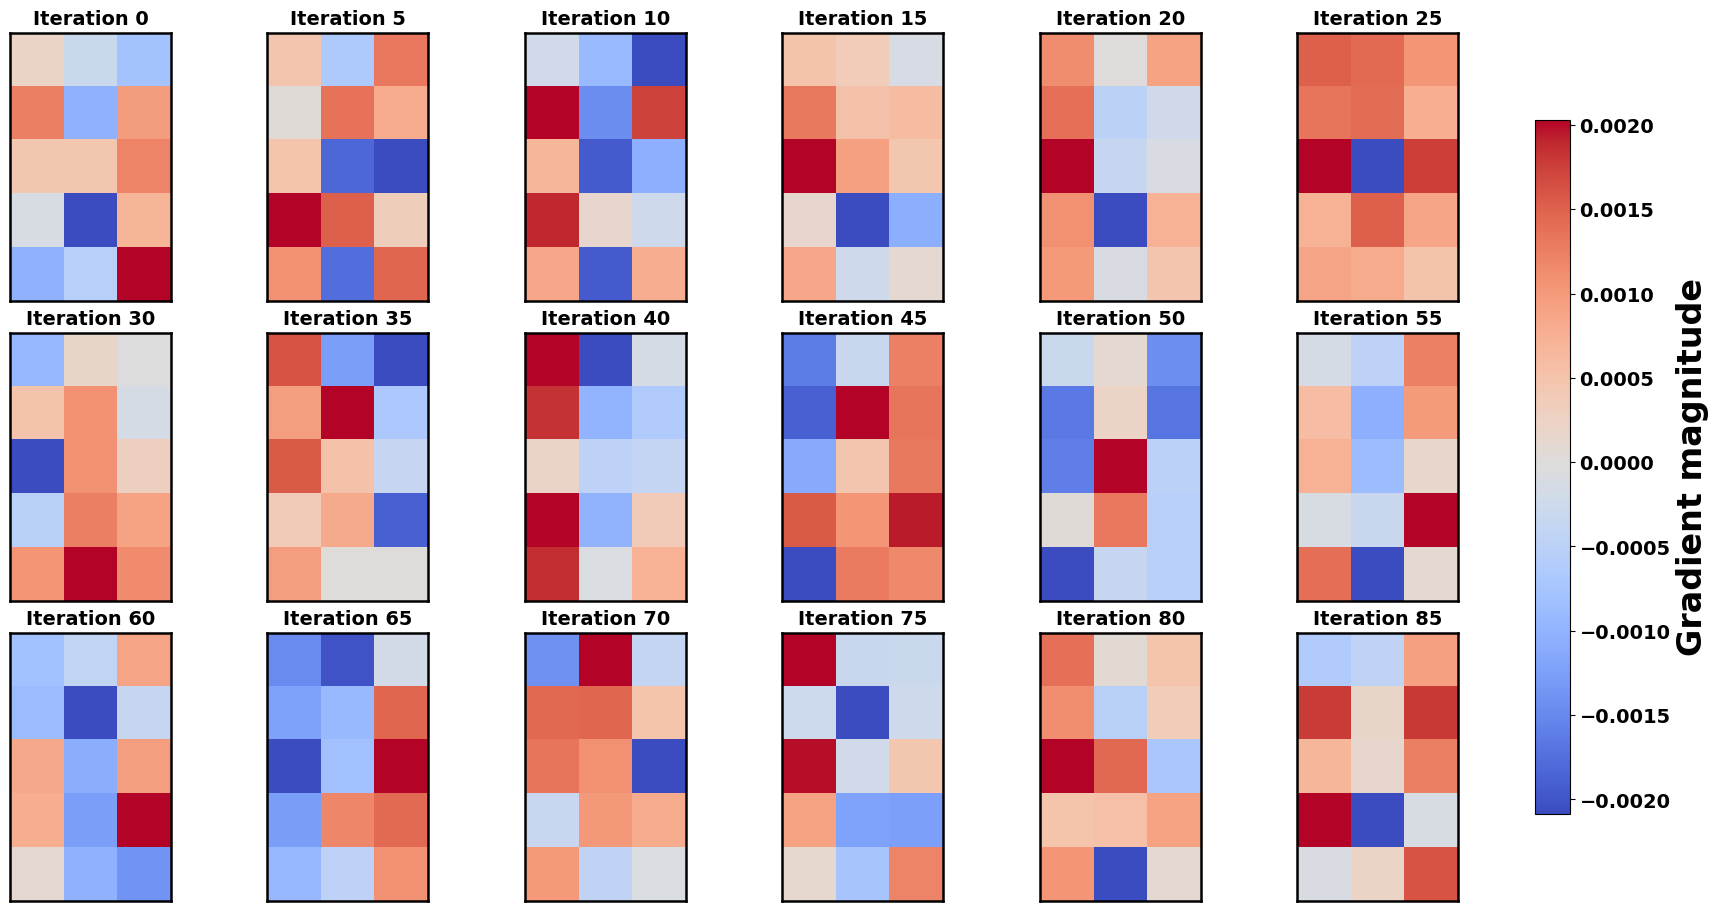

In [5]:
indices = list(range(0, len(heatmaps), 5))

n = len(indices)
ncols = int(n/3)
nrows = 3

fig, axes = plt.subplots(nrows, ncols, figsize=(3*ncols, 3*nrows),
                         constrained_layout=True)

axes = axes.flatten()

for ax, i in zip(axes, indices):
    im = ax.imshow(heatmaps[i], cmap="coolwarm")
    ax.set_title(f"Iteration {i}", fontsize=14, fontweight='bold')
    ax.set_xticks([])
    ax.set_yticks([])
    
    for spine in ax.spines.values():
        spine.set_linewidth(1.8)

for ax in axes[len(indices):]:
    ax.axis("off")

cbar = fig.colorbar(im, ax=axes.tolist(), shrink=0.8)
cbar.set_label("Gradient magnitude", fontsize=24, fontweight="bold")
cbar.ax.tick_params(labelsize=14)
for tick in cbar.ax.get_yticklabels():
    tick.set_fontweight("bold")
    
plt.show()

### Heatmap Evolution of the Expected Gradient

This cell visualises how the structure of the expected gradient
$$\mathbb{E}\!\left[\nabla_X (v^\top \cdot Y)\right]$$
evolves as the upstream weighting changes.

Rather than collapsing the gradient into a single number, we inspect its full matrix form at selected iterations.

--- 

### What is being shown?
- Each panel is a heatmap of the averaged gradient matrix $X_{\text{grad}}$ at a particular iteration.
- Rows correspond to rows of `X`; columns correspond to feature dimensions.
- Red and blue colours indicate positive and negative sensitivity, respectively.
- All heatmaps share the same colour scale, enabling direct visual comparison across iterations.
- Only every 5th iteration is shown to highlight structural evolution without overcrowding the figure.

---

### How to interpret the patterns
- The heatmaps show that while overall gradient magnitude changes smoothly, the spatial distribution of gradient entries fluctuates significantly.
- Different upstream weightings redistribute sensitivity across rows and columns rather than amplifying it uniformly.
- Symmetries imposed by the forward map $Y = \tanh(X X^\top)$ are preserved on average, but individual gradient realisations exhibit rich local structure.
- This confirms that gradient norms alone cannot capture directional information, which is essential for understanding optimisation behaviour.

---

### Why this visualisation matters

These heatmaps make explicit that:
- gradients are structured objects, not scalars,
- optimisation dynamics are governed by where gradients point, not just how large they are,
- and upstream objectives shape directional sensitivity even when total gradient mass is conserved.

This visual perspective provides the missing link between abstract gradient definitions and the concrete parameter updates that will be studied in Part 2.

## 🔗 Trailer: From Gradient Structure to a Single Update Step

So far in Part 1, we have treated gradients as objects to inspect rather than tools to use.
We decomposed them, visualised them, and asked where sensitivity lives inside a tensor.

Now we briefly connect that structure to motion.

### What is gradient descent?

At its simplest, gradient descent is a rule for updating parameters in order to reduce a scalar objective.

Given a scalar function
$$L(X),$$
a single gradient descent step with step size $\eta > 0$ is:
$$X_{\text{new}} = X - \eta \,\nabla_X L.$$

That’s it.

There is no optimiser, no momentum, no learning rate schedule — just:
- a gradient (direction),
- and a step size (scale).

### What is the “loss” in our case?

In this notebook, we did not define a conventional loss function.

Instead, we implicitly defined a scalar objective via an upstream gradient:
$$L(X) = v^\top \cdot Y,
\quad \text{where } Y = \tanh(X X^\top).$$

The gradient we computed and visualised throughout this workshop is therefore:
$$\nabla_X (v^\top \cdot Y).$$

Every heatmap you plotted is a **map of how a single gradient descent step would move `X`.**

### One explicit update step

Using the averaged gradient you computed, a single update would be:
$$X_{\text{new}} = X - \eta \,\nabla_X (v^\top \cdot Y).$$

What does this mean in practice?
- Each entry of `X` moves in the direction indicated by the heatmap.
- Regions with larger magnitude move **more strongly**.
- Positive and negative regions correspond to opposing update directions, not just strength.
- The update respects:
    - the symmetry of $X X^\top$,
    - the structure imposed by the upstream weighting `v`,
    - and the nonlinear gating of tanh.

Nothing “new” happens here.

Optimisation is simply **repeated application of the sensitivity patterns** you have already analysed.

### Why this closes Part 1 (and previews Part 2)

In Part 1, gradients were treated as:
- quantities to compute,
- structures to interpret,
- and signals to decompose.

This final step shows that:
- **every optimisation algorithm is just a rule for turning gradients into motion**,
- the heatmaps you plotted literally encode *where parameters will move next*,
- upstream objectives shape optimisation *before* any optimiser is introduced.

In **Part 2**, we will:
- repeat this step many times,
- vary step size $\eta$,
- introduce conditioning, curvature, and geometry,
- and study how these local updates accumulate into global behaviour.

Conceptually, nothing new is added — only repetition.

That repetition is optimisation.